# TP2 Projeto de Bloco: Inteligência Artificial e Machine Learning [24E3_5]
# Alberto F. Pluecker - 23.09.2024
https://colab.research.google.com/drive/1wgksoDqa4pb3l3XTkBOg0MRZwvE4oIiQ?usp=sharing

In [6]:
import nltk
from nltk.corpus import movie_reviews
import numpy as np

nltk.download('movie_reviews')

reviews = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


## 1. Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar a importância das palavras em um conjunto de documentos.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = [" ".join(doc) for doc, category in reviews]

# criar o vetorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)

# computar a matriz TF-IDF
tfidf_matrix = vectorizer.fit_transform(texts)

print(f"Formato Matriz TF-IDF: {tfidf_matrix.shape}")
print(f"Features (palavras):\n{vectorizer.get_feature_names_out()}")

Formato Matriz TF-IDF: (2000, 1000)
Features (palavras):
['10' 'ability' 'able' 'about' 'above' 'absolutely' 'across' 'act'
 'acting' 'action' 'actor' 'actors' 'actress' 'actual' 'actually' 'add'
 'after' 'again' 'against' 'age' 'agent' 'ago' 'air' 'alien' 'aliens'
 'all' 'allen' 'almost' 'alone' 'along' 'already' 'also' 'although'
 'always' 'am' 'amazing' 'america' 'american' 'among' 'an' 'and'
 'animated' 'animation' 'annoying' 'another' 'any' 'anyone' 'anything'
 'anyway' 'apparently' 'appear' 'appears' 'are' 'aren' 'army' 'around'
 'art' 'as' 'ask' 'aspect' 'at' 'atmosphere' 'attempt' 'attempts'
 'attention' 'audience' 'audiences' 'away' 'back' 'bad' 'based'
 'basically' 'batman' 'battle' 'be' 'beautiful' 'because' 'become'
 'becomes' 'been' 'before' 'begin' 'beginning' 'begins' 'behind' 'being'
 'believe' 'ben' 'best' 'better' 'between' 'beyond' 'big' 'biggest' 'bill'
 'bit' 'black' 'blood' 'bob' 'body' 'bond' 'book' 'boring' 'both' 'box'
 'boy' 'break' 'brief' 'brilliant' 'bring'

A matriz resultante tem dimensões [ n° reviews x n° features ] e representa a importância relativa de cada palavra no conjunto de reviews.

## 2. Modelagem de K-Nearest Neighbors (KNN): Criar modelos simples de classificação utilizando a base de dados codificada por TF-IDF. Explore diferentes valores para o parâmetro K do KNN e analise seu impacto nos resultados obtidos (através da acurácia do modelo para os dados de validação).

In [10]:
from typing import List
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, [category for doc, category in reviews], test_size=0.2, random_state=42)

# evaluate_knn avalia o KNN para diferentes valores de K
def evaluate_knn(k_values):
    accuracies = []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    return accuracies

k_values = [1, 3, 5, 7, 9]
accuracies = evaluate_knn(k_values)

for k, acc in zip(k_values, accuracies):
    print(f"K = {k}: Acurácia = {acc:.4f}")


K = 1: Acurácia = 0.6475
K = 3: Acurácia = 0.6375
K = 5: Acurácia = 0.6300
K = 7: Acurácia = 0.6425
K = 9: Acurácia = 0.6200


Com valor de K muito baixo (por exemplo, K=1) o modelo pode sofrer com overfitting, capturando muito ruído.

Um K muito alto pode suavizar demais as previsões, resultando em um modelo que não representa as nuances dos dados precisamente.

Com base na análise acima, K=5 ou K=7 parecem ser boas escolhas.

## 3. Avaliação de Modelos: Aplicar técnicas de validação cruzada para estimar a eficiência dos modelos desenvolvidos.

In [12]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=5)

# cross-validation com 5 folds
cv_scores = cross_val_score(knn, tfidf_matrix, [category for doc, category in reviews], cv=5)

print(f"Resultado da Cross-validation para cada fold: {cv_scores}")

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f"Acurácia média: {mean_cv_score:.4f}")
print(f"Desvio Padrão: {std_cv_score:.4f}")


Resultado da Cross-validation para cada fold: [0.5575 0.655  0.645  0.635  0.6275]
Acurácia média: 0.6240
Desvio Padrão: 0.0345


## 4. Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade para avaliar os modelos.

Relatório de Classificação:
              precision    recall  f1-score   support

         neg       0.76      0.38      0.50       199
         pos       0.59      0.88      0.71       201

    accuracy                           0.63       400
   macro avg       0.67      0.63      0.60       400
weighted avg       0.67      0.63      0.60       400



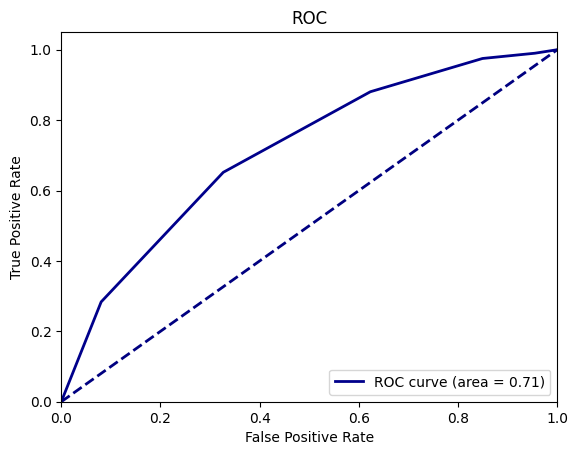

Sensibilidade (Recall): 0.8806
Especificidade: 0.3769


In [14]:
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# obter as probabilidades para a curva ROC
y_prob = knn.predict_proba(X_test)[:, 1]

# gerar relatório de classificação (precisão, recall, f1-score)
print("Relatório de Classificação:")
print(classification_report(y_test, y_pred))

# curva ROC
fpr, tpr, thresholds = roc_curve([1 if label == 'pos' else 0 for label in y_test], y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

# matriz de confusão para calcular sensibilidade e especificidade
conf_matrix = confusion_matrix([1 if label == 'pos' else 0 for label in y_test], [1 if label == 'pos' else 0 for label in y_pred])
tn, fp, fn, tp = conf_matrix.ravel()

# calcular sensibilidade e especificidade
sensibilidade = tp / (tp + fn)
especificidade = tn / (tn + fp)

print(f"Sensibilidade (Recall): {sensibilidade:.4f}")
print(f"Especificidade: {especificidade:.4f}")


## 5. Baseado nos valores encontrados para as diferentes figuras de mérito, interprete os resultados e disserte sobre a eficiência do classificador criado.

O modelo tem uma acurácia geral de 63%, indicando que ele faz um trabalho mediano na classificação dos exemplos. Ele se sai melhor na detecção da classe positiva (pos), com uma precisão de 0.59 e um recall de 0.88, resultando em um F1-score de 0.71. Isso significa que o modelo é bom em capturar exemplos verdadeiramente positivos, mas tem uma taxa moderada de falsos positivos. Por outro lado, o desempenho na classe negativa (neg) é significativamente pior, com um recall de apenas 0.38 e um F1-score de 0.50, mostrando que o modelo tem dificuldade em identificar corretamente os exemplos negativos e deixa muitos passar.

A sensibilidade alta na classe positiva (88%) sugere que o modelo é adequado para situações onde identificar positivos é mais importante. Porém, a baixa especificidade na classe negativa mostra que ele não é eficiente em evitar falsos negativos, o que pode ser crítico em certos cenários.

Para melhorar o desempenho, seria interessante testar diferentes valores de K no KNN. Também pode ser vantajoso experimentar outros algoritmos, para ver se conseguem melhorar o balanceamento entre precisão e recall nas duas classes.